# Initialization Stability

Here we examine the reproducibility of our initial results that FPR gets worse over time by testing many random seeds and creating boxplots for initial and updated FPR

In [60]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, make_gaussian_data

%matplotlib inline

## `sklearn.datasets.make_classification` Data | num_features=2

In [84]:
n_train = 10000
n_update = 10000
n_test = 10000

In [85]:
seeds = np.arange(1000)
initial_fprs_sklearn = []
updated_fprs_sklearn = []

for seed in seeds:
    np.random.seed(seed)

    x, y = make_classification(n_train + n_update + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs_sklearn.append(initial_fpr)
    updated_fprs_sklearn.append(updated_fpr)

In [62]:
fprs_sklearn_boxplot = {"type": (["initial"] * len(initial_fprs_sklearn)) + (["updated"] * len(updated_fprs_sklearn)),
        "fpr": initial_fprs_sklearn + updated_fprs_sklearn}
fprs_sklearn_scatterplot = {"initial_fpr": initial_fprs_sklearn, "updated_fpr": updated_fprs_sklearn}

In [63]:
data_sklearn_boxplot = pd.DataFrame(fprs_sklearn_boxplot)
data_sklearn_scatterplot = pd.DataFrame(fprs_sklearn_scatterplot)

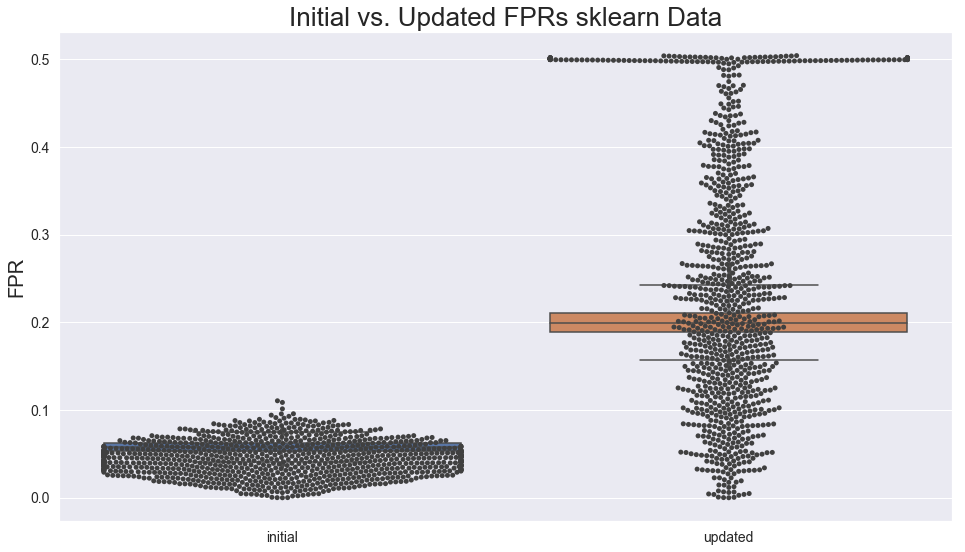

In [64]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data_sklearn_boxplot, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs sklearn Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

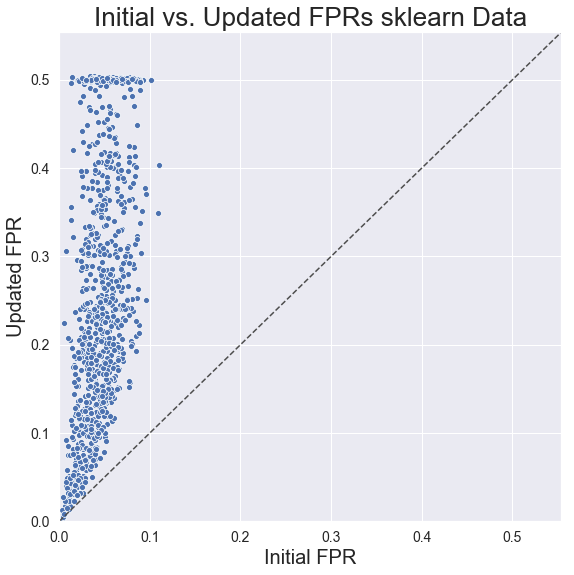

In [65]:
min_fpr = min(fprs_sklearn_scatterplot["initial_fpr"] + fprs_sklearn_scatterplot["updated_fpr"])
max_fpr = max(fprs_sklearn_scatterplot["initial_fpr"] + fprs_sklearn_scatterplot["updated_fpr"])
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
sns.scatterplot(x="initial_fpr", y="updated_fpr", data=data_sklearn_scatterplot, ax=ax)
ax.set_xlabel("Initial FPR", size=20)
ax.set_ylabel("Updated FPR", size=20)
ax.set_ylim([0, max_fpr + 0.05])
ax.set_xlim([0, max_fpr + 0.05])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Initial vs. Updated FPRs sklearn Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

In [66]:
arr_init = np.array(initial_fprs)
arr_updated = np.array(updated_fprs)

In [67]:
differences = arr_updated - arr_init

Text(0.5, 1.0, 'Distribution of (Updated - Initial) FPRs')

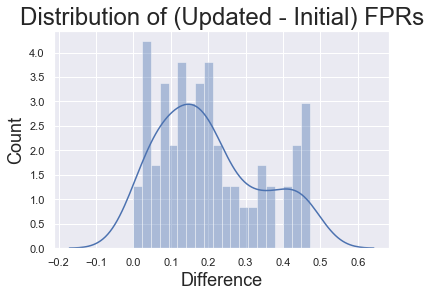

In [68]:
ax = sns.distplot(differences, bins=20)
ax.set_xlabel("Difference", size=18)
ax.set_ylabel("Count", size=18)
ax.set_title("Distribution of (Updated - Initial) FPRs", size=24)

In [69]:
print(pearsonr(initial_fprs, updated_fprs))
print(spearmanr(initial_fprs, updated_fprs))

(0.5174278599466771, 3.5403131722787794e-08)
SpearmanrResult(correlation=0.532176814214259, pvalue=1.2103798253423762e-08)


## Gaussian Data | num_features = 2

In [77]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

n_features = 2

In [ ]:
n_train = 10000
n_update = 10000
n_test = 10000

In [78]:
seeds = np.arange(1000)
initial_fprs_gaussian = []
updated_fprs_gaussian = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=n_features)
    
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs_gaussian.append(initial_fpr)
    updated_fprs_gaussian.append(updated_fpr)

In [79]:
fprs_gaussian_boxplot = {"type": (["initial"] * len(initial_fprs_gaussian)) + (["updated"] * len(updated_fprs_gaussian)),
        "fpr": initial_fprs_gaussian + updated_fprs_gaussian}
fprs_gaussian_scatterplot = {"initial_fpr": initial_fprs_gaussian, "updated_fpr": updated_fprs_gaussian}

In [80]:
data_gaussian_boxplot = pd.DataFrame(fprs_gaussian_boxplot)
data_gaussian_scatterplot = pd.DataFrame(fprs_gaussian_scatterplot)

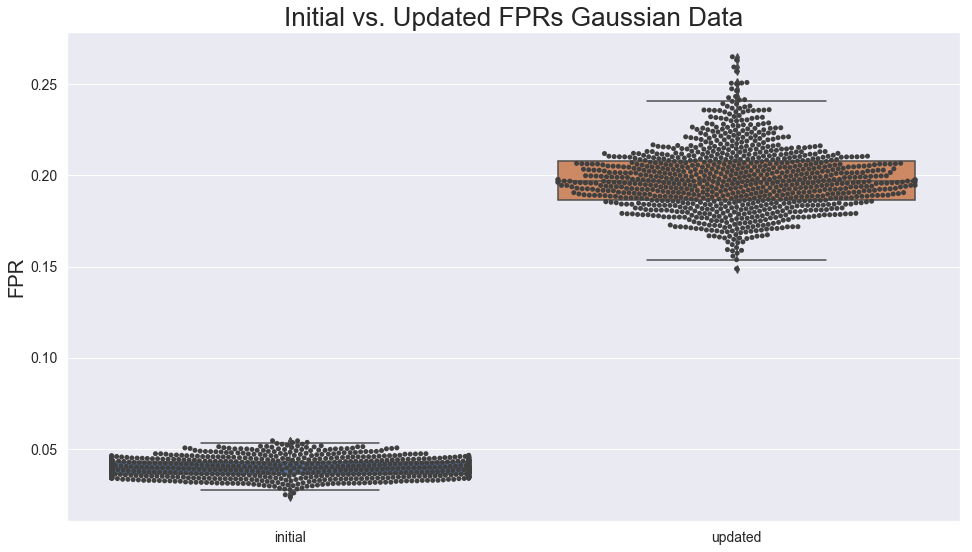

In [82]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data_gaussian_boxplot, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data_gaussian_boxplot, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs Gaussian Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

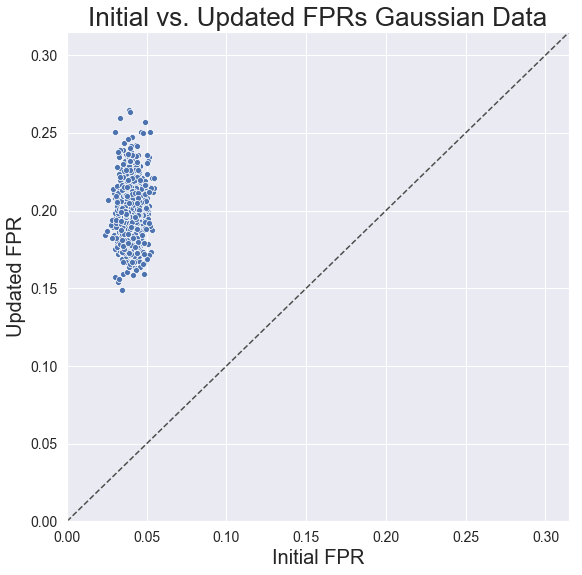

In [83]:
max_fpr = max(fprs_gaussian_scatterplot["initial_fpr"] + fprs_gaussian_scatterplot["updated_fpr"])
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
sns.scatterplot(x="initial_fpr", y="updated_fpr", data=data_gaussian_scatterplot, ax=ax)
ax.set_xlabel("Initial FPR", size=20)
ax.set_ylabel("Updated FPR", size=20)
ax.set_ylim([0, max_fpr + 0.05])
ax.set_xlim([0, max_fpr + 0.05])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Initial vs. Updated FPRs Gaussian Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

## Gaussian Quantile Data

Here the data looks like it's from two different concentric circles with the center of each circle being the opposite class --> not linearly separatbl